In [3]:
pip install torchvision


  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/59/af/426c2b90f5c4f8aba778746465af9e662680570e950e02379e91c6138285/torchvision-0.16.0-cp310-cp310-win_amd64.whl.metadata
  Using cached torchvision-0.16.0-cp310-cp310-win_amd64.whl.metadata (6.6 kB)
Using cached torchvision-0.16.0-cp310-cp310-win_amd64.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

Epoch 0, train loss: 1.3948007971048355, val loss: 1.3811688621838887, val Accuracy: 29.17%'
Epoch 1, train loss: 1.3824366629123688, val loss: 1.3749680320421855, val Accuracy: 29.17%'
Epoch 2, train loss: 1.3783705681562424, val loss: 1.365689992904663, val Accuracy: 62.50%'
Epoch 3, train loss: 1.3723751207192738, val loss: 1.358556005689833, val Accuracy: 45.83%'
Epoch 4, train loss: 1.3665720572074254, val loss: 1.351856741640303, val Accuracy: 45.83%'
Epoch 5, train loss: 1.3599610527356465, val loss: 1.3458926015430026, val Accuracy: 38.89%'
Epoch 6, train loss: 1.3454713076353073, val loss: 1.32885918352339, val Accuracy: 45.83%'
Epoch 7, train loss: 1.3299423058827717, val loss: 1.3179377052519057, val Accuracy: 47.22%'
Epoch 8, train loss: 1.3236653010050456, val loss: 1.3075556887520685, val Accuracy: 44.44%'
Epoch 9, train loss: 1.3242849012215931, val loss: 1.2955903477138944, val Accuracy: 48.61%'
Epoch 10, train loss: 1.3104922473430634, val loss: 1.303062617778778, val 

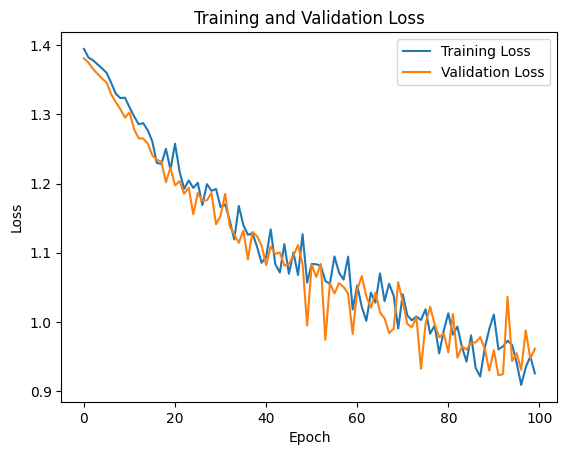

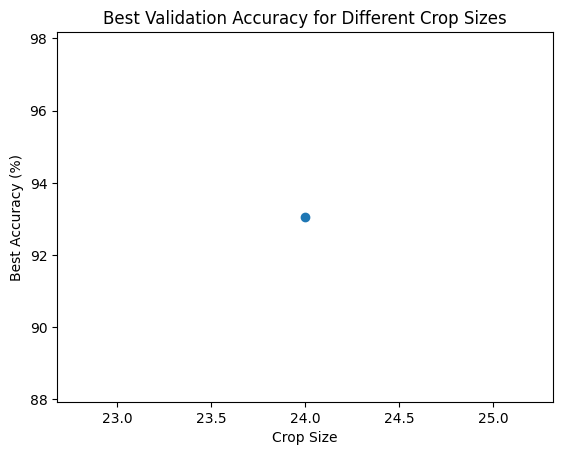

In [22]:

# Define a list of crop sizes to experiment with
crop_sizes = [16, 20, 24]

# Lists to store the best accuracies for each crop size
best_accuracies_dict = {}
best_accuracies = {}


for crop_size in crop_sizes:
    # Define data transformations with the current crop size
    transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((crop_size, crop_size))])




# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):

        folders = os.listdir(root)
        self.data = []
        self.labels = []

        self.label_map = {"empty": 0,
                          "sit": 1,
                          "stand": 2,
                          "walk": 3}

        for folder in folders:
            path = os.path.join(root, folder)
            label_folders = os.listdir(path)
            for label_folder in label_folders:
                label_path = os.path.join(path, label_folder)
                for file in os.listdir(label_path):
                    data_file = os.path.join(path, label_folder, file)
                    if "image" in file:
                        self.data.append(data_file)
                        self.labels.append(label_folder)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        image = image.resize((34, 34), Image.NEAREST)

        label = self.label_map[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your CNN architecture
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 4)  # 10 output classes


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


# Define your data transformations and load data
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((24,24))])

# Load your custom dataset here
# Replace 'data' and 'labels' with your actual data
train_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//train/", transform=transform)
val_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//val/", transform=transform)

# Define dataloader
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 100  # Adjust as needed
best_acc = 0

# Lists to store training and validation loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        '''if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item()}')'''


    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    # Append training and validation loss values to the lists
    train_losses.append(train_loss / len(dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    
    if best_acc < accuracy:
        best_acc  = accuracy
        
    if best_accuracies_dict.get(crop_size) is None or best_accuracies_dict[crop_size] < accuracy:
            best_accuracies_dict[crop_size] = accuracy
    
    

    print(f"Epoch {epoch}, train loss: {(train_loss) / len(dataloader)}, val loss: {(val_loss) / len(val_dataloader)}, val Accuracy: {accuracy:.2f}%'")
# Save the trained model if needed
torch.save(model.state_dict(), 'custom_cnn_model.pth')
print("Best acc: ", best_acc)
# Plot training and validation loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure()
plt.plot(list(best_accuracies_dict.keys()), list(best_accuracies_dict.values()), marker='o')
plt.xlabel("Crop Size")
plt.ylabel("Best Accuracy (%)")
plt.title("Best Validation Accuracy for Different Crop Sizes")
plt.show()

Epoch 0, train loss: 1.3877648164828618, val loss: 1.3772219485706754, val Accuracy: 25.00%'
Epoch 1, train loss: 1.3718728870153427, val loss: 1.3623812993367512, val Accuracy: 30.56%'
Epoch 2, train loss: 1.3511600742737453, val loss: 1.3385849197705586, val Accuracy: 44.44%'
Epoch 3, train loss: 1.3401016741991043, val loss: 1.3326532708273993, val Accuracy: 36.11%'
Epoch 4, train loss: 1.3184620787700017, val loss: 1.3193750580151875, val Accuracy: 40.28%'
Epoch 5, train loss: 1.317752222220103, val loss: 1.2840477890438504, val Accuracy: 50.00%'
Epoch 6, train loss: 1.3120245685180028, val loss: 1.2776441441641913, val Accuracy: 54.17%'
Epoch 7, train loss: 1.2913683702548344, val loss: 1.2574330502086215, val Accuracy: 47.22%'
Epoch 8, train loss: 1.2561272929112117, val loss: 1.2544502019882202, val Accuracy: 51.39%'
Epoch 9, train loss: 1.2668818136056264, val loss: 1.2413065830866497, val Accuracy: 63.89%'
Epoch 10, train loss: 1.2671523988246918, val loss: 1.2389281060960557,

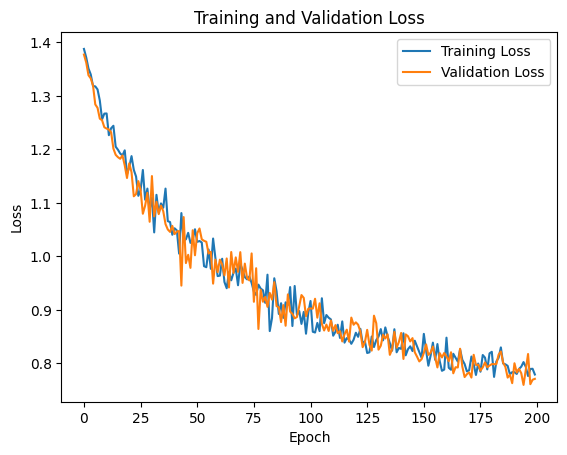

ValueError: x and y must have same first dimension, but have shapes (3,) and (200,)

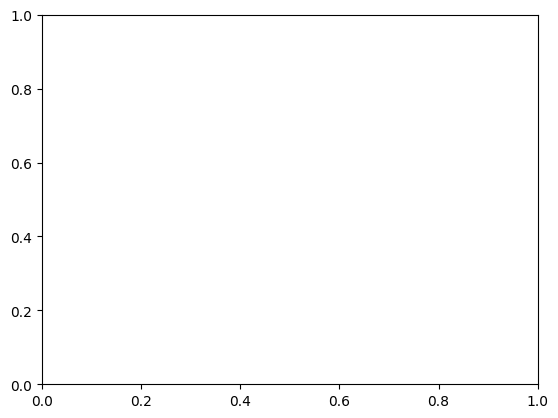

In [2]:



# Define a list of crop sizes to experiment with
crop_sizes = [16, 20, 24]

# Lists to store the best accuracies for each crop size
best_accuracies = []

for crop_size in crop_sizes:
    # Define data transformations with the current crop size
    transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((crop_size, crop_size))])




# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):

        folders = os.listdir(root)
        self.data = []
        self.labels = []

        self.label_map = {"empty": 0,
                          "sit": 1,
                          "stand": 2,
                          "walk": 3}

        for folder in folders:
            path = os.path.join(root, folder)
            label_folders = os.listdir(path)
            for label_folder in label_folders:
                label_path = os.path.join(path, label_folder)
                for file in os.listdir(label_path):
                    data_file = os.path.join(path, label_folder, file)
                    if "image" in file:
                        self.data.append(data_file)
                        self.labels.append(label_folder)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        image = image.resize((34, 34), Image.NEAREST)

        label = self.label_map[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your CNN architecture
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 4)  # 10 output classes


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


# Define your data transformations and load data
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((24,24))])

# Load your custom dataset here
# Replace 'data' and 'labels' with your actual data
train_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//train/", transform=transform)
val_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//val/", transform=transform)

# Define dataloader
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 200  # Adjust as needed
best_acc = 0
best_accuracies = []

# Lists to store training and validation loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        '''if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item()}')'''


    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    # Append training and validation loss values to the lists
    train_losses.append(train_loss / len(dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    if best_acc < accuracy:
        best_acc  = accuracy
        
    best_accuracies.append(best_acc)        

    print(f"Epoch {epoch}, train loss: {(train_loss) / len(dataloader)}, val loss: {(val_loss) / len(val_dataloader)}, val Accuracy: {accuracy:.2f}%'")
# Save the trained model if needed
torch.save(model.state_dict(), 'custom_cnn_model.pth')
print("Best acc: ", best_acc)
# Plot training and validation loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show("temp.png")

plt.figure()
plt.plot(crop_sizes, best_accuracies, marker='o')
plt.xlabel("Crop Size")
plt.ylabel("Best Accuracy (%)")
plt.title("Best Validation Accuracy for Different Crop Sizes")
plt.show("temp2.png")

Epoch 0, train loss: 1.4039808809757233, val loss: 1.3806651896900601, val Accuracy: 43.06%'
Epoch 1, train loss: 1.3779651870330174, val loss: 1.3716251254081726, val Accuracy: 40.28%'
Epoch 2, train loss: 1.3724024097124736, val loss: 1.3644854691293504, val Accuracy: 43.06%'
Epoch 3, train loss: 1.3650904993216197, val loss: 1.355497870180342, val Accuracy: 37.50%'
Epoch 4, train loss: 1.3565651923418045, val loss: 1.3391561441951327, val Accuracy: 41.67%'
Epoch 5, train loss: 1.3506896843512852, val loss: 1.332764936818017, val Accuracy: 50.00%'
Epoch 6, train loss: 1.3416081964969635, val loss: 1.3159682618247137, val Accuracy: 45.83%'
Epoch 7, train loss: 1.3144081085920334, val loss: 1.3066162202093337, val Accuracy: 48.61%'
Epoch 8, train loss: 1.32215516269207, val loss: 1.305941151248084, val Accuracy: 54.17%'
Epoch 9, train loss: 1.3048739383618038, val loss: 1.2955763339996338, val Accuracy: 59.72%'
Epoch 10, train loss: 1.3086916655302048, val loss: 1.281333651807573, val 

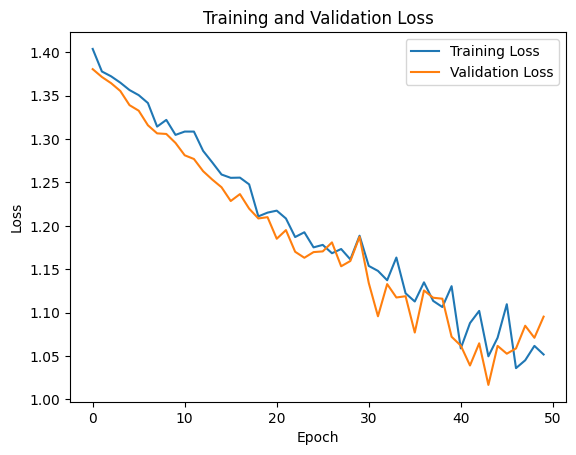

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):

        folders = os.listdir(root)
        self.data = []
        self.labels = []

        self.label_map = {"empty": 0,
                          "sit": 1,
                          "stand": 2,
                          "walk": 3}

        for folder in folders:
            path = os.path.join(root, folder)
            label_folders = os.listdir(path)
            for label_folder in label_folders:
                label_path = os.path.join(path, label_folder)
                for file in os.listdir(label_path):
                    data_file = os.path.join(path, label_folder, file)
                    if "image" in file:
                        self.data.append(data_file)
                        self.labels.append(label_folder)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        image = image.resize((34, 34), Image.NEAREST)

        label = self.label_map[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your CNN architecture
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 4)  # 10 output classes


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


# Define your data transformations and load data
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((24,24))])

# Load your custom dataset here
# Replace 'data' and 'labels' with your actual data
train_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//train/", transform=transform)
val_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//val/", transform=transform)

# Define dataloader
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50  # Adjust as needed
best_acc = 0

# Lists to store training and validation loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        '''if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item()}')'''


    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    # Append training and validation loss values to the lists
    train_losses.append(train_loss / len(dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    if best_acc < accuracy:
        best_acc  = accuracy

    print(f"Epoch {epoch}, train loss: {(train_loss) / len(dataloader)}, val loss: {(val_loss) / len(val_dataloader)}, val Accuracy: {accuracy:.2f}%'")
# Save the trained model if needed
torch.save(model.state_dict(), 'custom_cnn_model.pth')
print("Best acc: ", best_acc)
# Plot training and validation loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Define a list of crop sizes to experiment with
crop_sizes = [16, 20, 24]

# Lists to store the best accuracies for each crop size
best_accuracies_dict = {}
best_accuracies = {}


for crop_size in crop_sizes:
    # Define data transformations with the current crop size
    transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((crop_size, crop_size))])




# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):

        folders = os.listdir(root)
        self.data = []
        self.labels = []

        self.label_map = {"empty": 0,
                          "sit": 1,
                          "stand": 2,
                          "walk": 3}

        for folder in folders:
            path = os.path.join(root, folder)
            label_folders = os.listdir(path)
            for label_folder in label_folders:
                label_path = os.path.join(path, label_folder)
                for file in os.listdir(label_path):
                    data_file = os.path.join(path, label_folder, file)
                    if "image" in file:
                        self.data.append(data_file)
                        self.labels.append(label_folder)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        image = image.resize((34, 34), Image.NEAREST)

        label = self.label_map[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your CNN architecture
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 4)  # 10 output classes


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


# Define your data transformations and load data
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((24,24))])

# Load your custom dataset here
# Replace 'data' and 'labels' with your actual data
train_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//train/", transform=transform)
val_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//temp_train_dir//data//val/", transform=transform)

# Define dataloader
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
# Adjust as needed
best_acc = 0

# Lists to store training and validation loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        '''if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item()}')'''


    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    # Append training and validation loss values to the lists
    train_losses.append(train_loss / len(dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    if best_acc < accuracy:
        best_acc  = accuracy
         
    for crop_size, best_accuracy in zip(crop_sizes, best_accuracies):
        best_accuracies_dict[crop_size] = best_accuracy      

    print(f"Epoch {epoch}, train loss: {(train_loss) / len(dataloader)}, val loss: {(val_loss) / len(val_dataloader)}, val Accuracy: {accuracy:.2f}%'")
# Save the trained model if needed
torch.save(model.state_dict(), 'custom_cnn_model.pth')
print("Best acc: ", best_acc)
# Plot training and validation loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

plt.figure()
plt.plot(list(best_accuracies_dict.keys()), list(best_accuracies_dict.values()), marker='o')
plt.xlabel("Crop Size")
plt.ylabel("Best Accuracy (%)")
plt.title("Best Validation Accuracy for Different Crop Sizes")
plt.show()

Epoch 0, train loss: 1.3926755040884018, val loss: 1.385501522413442, val Accuracy: 23.76%'
Epoch 1, train loss: 1.3784211923678715, val loss: 1.383411922924955, val Accuracy: 25.53%'
Epoch 2, train loss: 1.3707247078418732, val loss: 1.3767279722321202, val Accuracy: 31.56%'
Epoch 3, train loss: 1.358166938026746, val loss: 1.37264282434759, val Accuracy: 32.62%'
Epoch 4, train loss: 1.3548577278852463, val loss: 1.3691391944885254, val Accuracy: 35.11%'
Epoch 5, train loss: 1.3252697040637333, val loss: 1.3605508401360311, val Accuracy: 32.27%'
Epoch 6, train loss: 1.3295577963193257, val loss: 1.3630019711776518, val Accuracy: 31.56%'
Epoch 7, train loss: 1.3127762625614803, val loss: 1.3650211196550182, val Accuracy: 29.43%'
Epoch 8, train loss: 1.3208642154932022, val loss: 1.3588227319045805, val Accuracy: 29.08%'
Epoch 9, train loss: 1.2910859634478886, val loss: 1.3488901215539852, val Accuracy: 35.82%'
Epoch 10, train loss: 1.278094584743182, val loss: 1.3518281134081558, val 

KeyboardInterrupt: 

Epoch 0, train loss: 1.394199217359225, val loss: 1.383576470361629, val Accuracy: 29.43%'
Epoch 1, train loss: 1.3861569513877232, val loss: 1.3791217048403244, val Accuracy: 25.53%'
Epoch 2, train loss: 1.375505064924558, val loss: 1.3737326071295939, val Accuracy: 25.53%'
Epoch 3, train loss: 1.370307023326556, val loss: 1.3717566896492326, val Accuracy: 32.98%'
Epoch 4, train loss: 1.351670543352763, val loss: 1.364123220175085, val Accuracy: 25.53%'
Epoch 5, train loss: 1.350491131345431, val loss: 1.3593365961397197, val Accuracy: 25.53%'
Epoch 6, train loss: 1.3254684805870056, val loss: 1.3501351383370412, val Accuracy: 25.53%'
Epoch 7, train loss: 1.3227572987476985, val loss: 1.3414307345806713, val Accuracy: 26.24%'
Epoch 8, train loss: 1.3041983594497044, val loss: 1.3594318149794995, val Accuracy: 26.24%'
Epoch 9, train loss: 1.3046144793430965, val loss: 1.3289867354110934, val Accuracy: 32.98%'
Epoch 10, train loss: 1.289268692334493, val loss: 1.339555260161279, val Acc

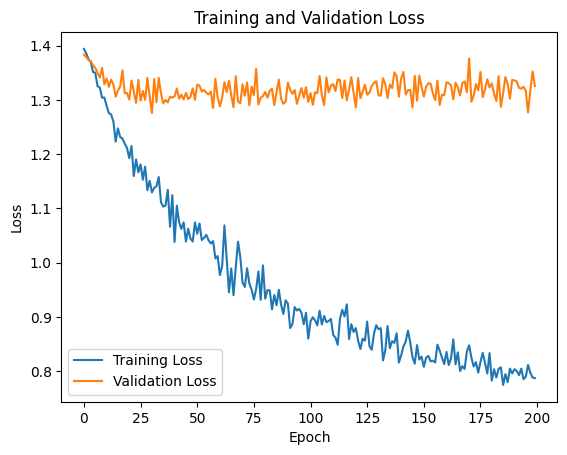

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import os
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Define your custom dataset
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):

        folders = os.listdir(root)
        self.data = []
        self.labels = []

        self.label_map = {"empty": 0,
                          "sit": 1,
                          "stand": 2,
                          "walk": 3}

        for folder in folders:
            path = os.path.join(root, folder)
            label_folders = os.listdir(path)
            for label_folder in label_folders:
                label_path = os.path.join(path, label_folder)
                for file in os.listdir(label_path):
                    data_file = os.path.join(path, label_folder, file)
                    if "image" in file:
                        self.data.append(data_file)
                        self.labels.append(label_folder)

        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        image = image.resize((34, 34), Image.NEAREST)

        label = self.label_map[self.labels[idx]]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define your CNN architecture
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 4)  # 10 output classes


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


# Define your data transformations and load data
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomCrop((24,24))])

# Load your custom dataset here
# Replace 'data' and 'labels' with your actual data
train_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//Temp_tanmay//data//train/", transform=transform)
val_dataset = CustomDataset(root="C://Users//Admin//OneDrive//Desktop//Thesis work//temp_train_dir//data//val/", transform=transform)

# Define dataloader
batch_size = 4
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model
model = CNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 200  # Adjust as needed
best_acc = 0

# Lists to store training and validation loss values
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    for i, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        '''if (i + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(dataloader)}], Loss: {loss.item()}')'''


    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(val_dataloader):
        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            total += labels.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    
    # Append training and validation loss values to the lists
    train_losses.append(train_loss / len(dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    if best_acc < accuracy:
        best_acc  = accuracy

    print(f"Epoch {epoch}, train loss: {(train_loss) / len(dataloader)}, val loss: {(val_loss) / len(val_dataloader)}, val Accuracy: {accuracy:.2f}%'")
# Save the trained model if needed
torch.save(model.state_dict(), 'custom_cnn_model.pth')
print("Best acc: ", best_acc)
# Plot training and validation loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label="Training Loss")
plt.plot(range(num_epochs), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("temp.png")